In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys 
import configparser
import pandas as pd 
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from os.path import join as oj

import pickle as pkl
sys.path.insert(0, "../src")
from utils.dice_score import multiclass_dice_coeff,dice_loss
import evaluate
from torch.utils.data import DataLoader, TensorDataset
import my_data
from unet import UNet
import pickle as pkl
pd.set_option('display.float_format', lambda x: '%.3f' % x)
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
config = configparser.ConfigParser()
config.read('../config.ini');
data_path =config['DATASET']['data_path'] 
from torch.nn import functional as F

In [2]:
fnames = sorted([oj(config['PATHS']['model_path'] , fname) for fname in os.listdir(config['PATHS']['model_path'] ) if "pkl" in fname]) 
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 

results = pd.concat(results_list, axis=1).T.infer_objects()

results.experiment_name.unique()
results['best_val_score'] = [max(x) for x in results.val_scores]
results[['foldername',  
         'final_dice_score','cost_function', 'add_ratio', 'test_dice_score',
         'experiment_name']].groupby([ 'experiment_name', 'cost_function','foldername','add_ratio', ]).mean()

final_dice_score  \
experiment_name            cost_function  foldername   add_ratio                     
ActiveLearning             cut_off_cost   lno_halfHour 0.010                 0.938   
                           random_cost    lno_halfHour 0.010                 0.932   
ActiveLearningRandomChoose cut_off_cost   lno_halfHour 0.010                 0.933   
                                                       0.020                 0.938   
                           num_pixel_cost lno_halfHour 0.010                 0.913   
                                                       0.020                 0.932   
                           random_cost    lno_halfHour 0.010                 0.929   
                                                       0.020                 0.923   
FullDataset                random_cost    lno          0.000                 0.946   
SubmissionModels           cut_off_cost   lno_halfHour 0.005                 0.914   
                                                       0.010                 0.937   
                           random_cost    lno_halfHour 0.000                 0.873   
                                                       0.005                 0.928   
                                                       0.010                 0.914   

                                                                  test_dice_score  
experiment_name            cost_function  foldername   add_ratio                   
ActiveLearning             cut_off_cost   lno_halfHour 0.010                0.967  
                           random_cost    lno_halfHour 0.010                0.966  
ActiveLearningRandomChoose cut_off_cost   lno_halfHour 0.010                0.969  
                                                       0.020                0.972  
                           num_pixel_cost lno_halfHour 0.010                0.964  
                                                       0.020                0.970  
                           random_cost    lno_halfHour 0.010                0.968  
                                                       0.020                0.968  
FullDataset                random_cost    lno          0.000                0.975  
SubmissionModels           cut_off_cost   lno_halfHour 0.005                0.962  
                                                       0.010                0.964  
                           random_cost    lno_halfHour 0.000                0.955  
                                                       0.005                0.964  
                                                       0.010                0.961

In [3]:
results = results[results['cost_function'] == 'cut_off_cost']
results = results[results['experiment_name'] == 'ActiveLearningRandomChoose']
#reindex
results = results.reset_index(drop=True)

In [17]:
x, y, num_classes, class_dict = my_data.load_layer_data( oj(config["DATASET"]["data_path"], 'lno') )
x_test, y_test = x[-1:], y[-1:]
x_test = (x_test - results.data_min[0]) / (results.data_max[0] - results.data_min[0])
num_classes = results.num_classes[0]

In [20]:
y_test.shape

(1, 2048, 2048)

In [21]:
def stack_imgs(x,y):
    x_return = np.vstack( [ x[:, :, :1024, :1024], x[:, :,  :1024, 1024:], 
                           x[:, :, 1024:, 1024:], x[:, :, 1024:, :1024], ] )
    y_return = np.vstack( [ y[:, :1024, :1024], y[:, :1024, 1024:], 
                           y[:,  1024:, 1024:], y[:,  1024:, :1024], ] )
    return x_return, y_return

In [22]:
x_test, y_test = stack_imgs(x_test, y_test)

In [24]:
y_test.shape

(4, 1024, 1024)

In [8]:
x_test, y_test = stack_imgs(x_test, y_test)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1 and the array at index 2 has size 0

In [6]:
x_test.shape

(1, 1, 2048, 2048)

In [5]:
for j in tqdm(range(len(results))):
    # if the file exists
    if os.path.exists(oj(config['PATHS']['model_path'] ,results.file_name[j]+".pt")):
        
        net = UNet(1, results.num_classes[0], )
        net.load_state_dict(torch.load(oj(config['PATHS']['model_path'] ,results.file_name[j]+".pt")))
        print(results.cost_function[j])
        net = net.to(device).eval()
        results.at[j, 'test_dice_score'] = evaluate.final_evaluate(net, x_test, y_test, num_classes, device)
        break

  0%|          | 0/6 [00:00<?, ?it/s]

cut_off_cost


OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 8.00 GiB total capacity; 7.26 GiB already allocated; 0 bytes free; 7.27 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [264]:
results[['foldername',  
         'test_dice_score','cost_function', 'add_ratio',
         'experiment_name']].groupby([ 'experiment_name', 'cost_function','foldername','add_ratio', ]).mean()

test_dice_score
experiment_name            cost_function foldername   add_ratio                 
ActiveLearningRandomChoose cut_off_cost  lno_halfHour 0.010                0.969
                                                      0.020                0.972

In [284]:
x_pool = my_data.load_pool_data( oj(config["DATASET"]["data_path"], 'lno') )
x_pool = x_pool[:-4]
x_pool = (x_pool.astype(np.float16) - results.data_min[0]) / (results.data_max[0] - results.data_min[0])
x_pool_all, slice_numbers = my_data.make_dataset_single( x_pool, 
                                                 img_size=128, 
                                                 offset=128,
                                                  return_slice_numbers= True )
     
pool_set = TensorDataset(torch.Tensor(x_pool_all))
loader_args = dict( batch_size=4, num_workers=0, pin_memory=True )
pool_loader = DataLoader(pool_set, shuffle=False, **loader_args)

In [285]:
x_pool.shape

(20, 1, 1024, 1024)

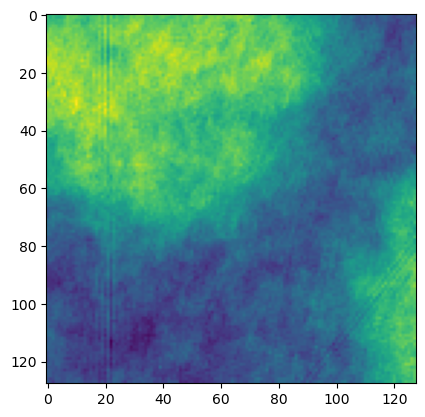

In [296]:
idx = 369
plt.imshow(pool_loader.dataset[idx][0][0], )

tensor(0.0813)


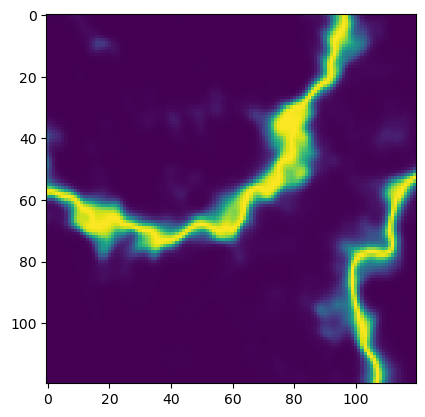

In [297]:
output = F.softmax(net.forward(pool_loader.dataset[idx][0][None,:].to(device)), dim=1)[:,:, 4:-4, 4:-4]
plt.imshow((-torch.sum(output * torch.log(output), dim=1))[0].detach().cpu())
print((-torch.sum(output * torch.log(output), dim=1))[0].detach().cpu().mean())

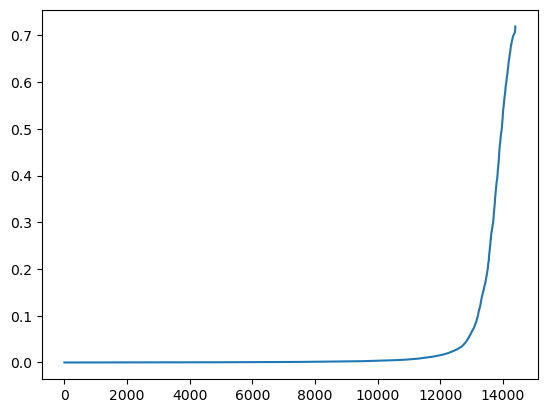

In [288]:
plt.plot((-torch.sum(output * torch.log(output), dim=1))[0].detach().cpu().reshape(-1).sort()[0])

In [291]:
net = net.to(device)
net.eval()
evaluate.cut_off_cost(net, device, pool_loader, percentile=.5,  n_choose=5)

array([833,  11, 369,  50, 883], dtype=int64)

In [302]:
net.forward(img_t).shape

torch.Size([1, 3, 1024, 1024])

In [320]:
img_idx = 1
test_img_np  = ((x_test[img_idx][None, ].astype(np.float32) ))
with torch.no_grad():
    img_t = torch.Tensor(test_img_np).to(device)
    output = F.softmax(net.forward(img_t), dim =1).cpu().detach().numpy()[0]

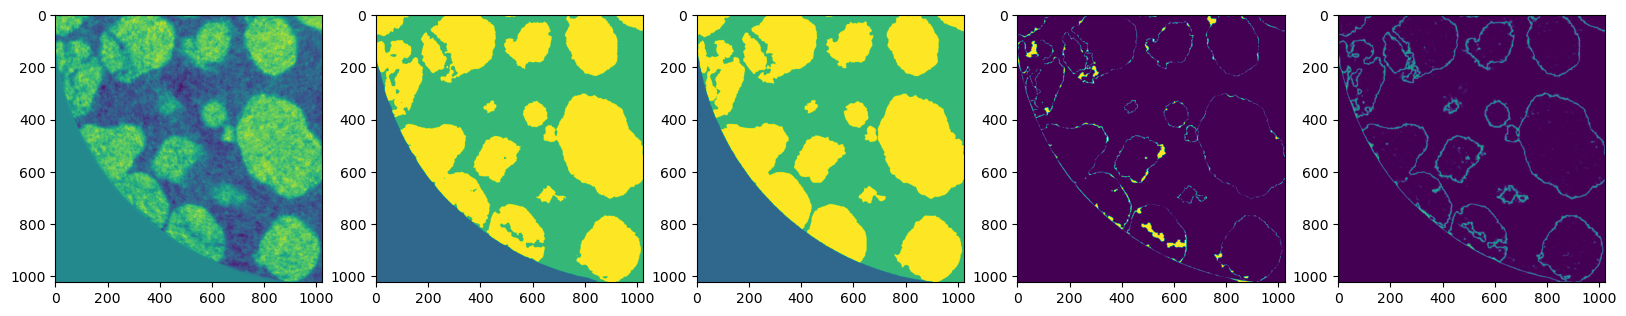

In [321]:
fig, axes = plt.subplots(ncols = 5, figsize = (20,4))
axes[0].imshow(x_test[img_idx][0])
axes[1].imshow(np.argmax(output, axis=0),vmin =-1, vmax = 2)
target = np.copy(y_test[img_idx]).astype(np.int16)
target[np.where(target == 255)] =-1
axes[2].imshow(target, vmin =-1,vmax = 2)
axes[3].imshow((target !=np.argmax(output, axis=0) ) * (target !=-1))

axes[4].imshow( (-output * np.log(output)).sum(axis=0))
# axes[1].imshow()

# try with detailed

In [ ]:
x,y,num_classes,_ = my_data.load_layer_data(oj(data_path, 'lno'))

x, y = x[:-4], y[:-4]  # just don't touch the last four
x = x/x.max()
val_percent = .25
init_train_ratio =1
image_size = 128
offset = 64
all_idxs = np.arange(len(x))
np.random.seed(0)
np.random.shuffle(all_idxs)
n_val = np.maximum(int(len(x) * val_percent), 1)
n_train = len(x) - n_val
all_train_idxs = all_idxs[:n_train]
val_idxs = all_idxs[n_train:]
init_train_idxs = all_train_idxs[: np.maximum(1, int(init_train_ratio * n_train))]
pool_idxs = all_train_idxs[np.maximum(1, int(init_train_ratio * n_train)) :]

val_set = TensorDataset(
    *[
        torch.Tensor(input)
        for input in my_data.make_dataset(
            x[val_idxs[:1]],
            y[val_idxs[:1]],
            img_size=image_size,
            offset=image_size,
        )
    ]
)
val_loader = DataLoader(val_set, shuffle=False, drop_last=False, batch_size = 16)

In [ ]:
val_loader.batch_size

In [ ]:
x_small, _,=my_data.make_dataset(
            x[val_idxs[:1]],
            y[val_idxs[:1]],
            img_size=image_size,
            offset=image_size,
        )

In [ ]:
x_small[test_idxes].min()

In [ ]:
net(t)

In [ ]:
x.shape

In [ ]:
val_loader

In [ ]:
net

In [ ]:
len(all_train_idxs)

In [ ]:
len(val_loader.dataset)

In [ ]:
plt.imshow(x[val_idxs[0]][0])

In [ ]:
test_ids_safe = std_cost_function(net, device,val_loader,n_choose =59)

# test_ids = np.argsort(test_ids_safe)

In [ ]:
len(val_loader.dataset)

In [ ]:
test_ids_safe

In [ ]:
plt.imshow(val_set[test_ids_safe[0]][0][0])

In [ ]:
plt.imshow(val_set[test_ids_safe[-20]][0][0])

In [ ]:
test_ids_safe[32]

In [ ]:
test_ids_safe[23]

In [ ]:
test_ids_safe

In [ ]:
test_ids_safe

In [ ]:
test_ids_safe

In [ ]:
test_ids_safe

In [ ]:
test_ids_safe

In [ ]:
net(val_set[test_ids_safe[1]][0][None,:].to(device))[0].std(dim=1).mean(dim=(0,1))

In [ ]:
net(val_set[test_ids_safe[-1]][0][None,:].to(device))[0].std(dim=1).mean(dim=(0,1))

In [ ]:
net(val_set[test_ids_safe[-1]][0][None,:].to(device))[0][0].mean()

In [ ]:
net(val_set[test_ids_safe[-1]][0][None,:].to(device))[0][2].mean()

In [ ]:
net(val_set[test_ids_safe[-1]][0][None,:].to(device))[0].std(dim=1)

In [ ]:
test_ids_safe[224]

In [ ]:
len(test_ids_safe)

In [ ]:
test_ids = np.sort(test_ids)

In [ ]:
plt.imshow(val_set[5][0][0])

In [ ]:
plt.imshow(val_set[test_ids[10]][0][0])

In [ ]:
plt.imshow(val_set[test_ids[1]][0][0])

In [ ]:
plt.imshow(val_set[test_ids[0]][0][0])

In [ ]:
img_idx = 0
test_img_np  = ((x[img_idx][None, ].astype(np.float32) ))
with torch.no_grad():
    img_t = torch.Tensor(test_img_np).to(device)
    output = F.softmax(net.forward(img_t)[0], dim =0).cpu().detach().numpy()


In [ ]:
fig, axes = plt.subplots(ncols = 5, figsize = (20,4))
axes[0].imshow(x[img_idx][0])
axes[1].imshow(np.argmax(output, axis=0),vmin =-1, vmax = 2)
target = np.copy(y[img_idx]).astype(np.int16)
target[np.where(target == 255)] =-1
axes[2].imshow(target, vmin =-1,vmax = 2)
axes[3].imshow((target !=np.argmax(output, axis=0) ))
max_val =np.quantile(output.std(axis=0).max() - output.std(axis=0),.90)
axes[4].imshow(output.std(axis=0).max() - output.std(axis=0),vmax = max_val)
# axes[1].imshow()

In [ ]:
output.std(axis=0).max() - output.std(axis=0)

In [ ]:
with torch.no_grad():
    img_t = torch.Tensor(x[val_idxs]).to(device)
    output = F.softmax(net.forward(img_t), dim =1)


In [ ]:
(torch.argmax(output, dim = 1).detach().cpu().numpy() ==y[val_idxs]).mean()

In [ ]:
(torch.argmax(output, dim = 1).detach().cpu().numpy() ==y[val_idxs])[np.where((my_std < np.quantile(my_std, .1)))].mean()

In [ ]:
(torch.argmax(output, dim = 1).detach().cpu().numpy() ==y[val_idxs])[np.where((my_std > np.quantile(my_std, .1)))].mean()

In [ ]:
len(val_loader)

In [ ]:
val_loader

In [ ]:
eva

In [ ]:
my_std = torch.std(output,dim =1).detach().cpu().numpy()

In [ ]:
torch.argmax(output, dim = 1)

In [ ]:
np.where((my_std < np.quantile(my_std, .1)))

In [ ]:
(torch.argmax(output, dim = 1).detach().cpu().numpy() ==y[val_idxs]).mean()

In [ ]:
output.shape

In [ ]:
1-dice_loss(output, torch.Tensor(y[val_idxs]).to(device), num_classes, multiclass=True)

In [ ]:
from dice_score import dice_loss

In [ ]:
dice_loss()

In [ ]:
num_classes

In [ ]:
np.quantile(output.std(axis=0).max() - output.std(axis=0), .9)

In [ ]:
output.std(axis=0).max()

In [ ]:
(target ==np.argmax(output, axis=0) ).mean()

In [ ]:
output.std(axis=0)

# old stuff

In [ ]:
for i in range(4):
    img_idx = i
    test_img_np  = ((x[img_idx][None, ].astype(np.float32) ))
    with torch.no_grad():
        img_t = torch.Tensor(test_img_np).to(device)
        output = net.forward(img_t).cpu().detach().numpy()[0]
        show_img = np.zeros_like(y[img_idx])
        show_img[np.where(y[img_idx] ==my_data.phase_1)] =1
        show_img[np.where(y[img_idx] ==my_data.phase_2)] =2
        print((show_img ==np.argmax(output, axis=0)).mean())


In [ ]:
img_idx = -1
test_img_np  = ((x[img_idx][None, ].astype(np.float32) -my_data.mean)/my_data.std)
with torch.no_grad():
    img_t = torch.Tensor(test_img_np).to(device)
    output = net.forward(img_t).cpu().detach().numpy()[0]


In [ ]:
show_img = np.zeros_like(y[img_idx])
show_img[np.where(y[img_idx] ==my_data.phase_1)] =1
show_img[np.where(y[img_idx] ==my_data.phase_2)] =2

In [ ]:
std_large = output.std(axis=0)<np.quantile(output.std(axis=0), .1)

fig, axes = plt.subplots(ncols = 5, figsize = (20,7))
axes[0].imshow(x[img_idx,2])
axes[1].imshow(np.argmax(output, axis=0))
axes[2].imshow(show_img)
axes[3].imshow(show_img !=np.argmax(output, axis=0) )

axes[4].imshow(std_large)

In [ ]:
x.shape

In [ ]:
std_large = output.std(axis=0)<np.quantile(output.std(axis=0), .05)

fig, axes = plt.subplots(ncols = 3, figsize = (20,8))
# axes[0].imshow(x[img_idx,2])
axes[0].imshow(np.argmax(output, axis=0))
# axes[2].imshow(show_img)
axes[1].imshow(show_img !=np.argmax(output, axis=0) )

axes[2].imshow(std_large)

In [ ]:
(show_img !=np.argmax(output, axis=0))[np.where(1-std_large)].mean()

In [ ]:
(show_img ==np.argmax(output, axis=0)).mean()

In [ ]:
correct = np.reshape(show_img !=np.argmax(output, axis=0),-1)
std = np.reshape(output.std(axis=0), -1)

In [ ]:
std_large = output.std(axis=0)<np.quantile(output.std(axis=0), .1)

fig, axes = plt.subplots(ncols = 5, figsize = (20,7))
axes[0].imshow(x[img_idx,2])
axes[1].imshow(np.argmax(output, axis=0))
axes[2].imshow(show_img)
axes[3].imshow(show_img !=np.argmax(output, axis=0) )

axes[4].imshow(std_large)

In [ ]:
std_large = output.std(axis=0)<np.quantile(output.std(axis=0), .1)

fig, axes = plt.subplots(ncols = 1, figsize = (20,7))
axes.imshow(x[img_idx,2][200:400,350:600])

# axes[4].imshow(std_large)

In [ ]:
x.shape

In [ ]:
plt.imshow(x[0,2])

In [ ]:
plt.imshow(x[-1,2])

In [ ]:
x[img_idx,2][200:400,350:600]